In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [18]:
sigma = 15
wx = int(600) # rolling window size in x-direction
datestart, dateend = "2012-01-01", "2012-01-25"
experiment_name = "INALT60.L120-KRS0020"  
data_resolution = "1d"

# detection parameters
params = 'OW0.2_Npix-2025-15000' # 'OW0.5_Npix-1296-32400'
Npix_min = 720
Npix_max = 500*6*6
OW_thr_factor =-0.3

In [19]:
params = f'OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}'

In [ ]:
ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/Parcels-mask_depths-48_{datestart.replace("-", "")}_{dateend.replace("-", "")}_{params}_rolling-{wx}.nc')

In [21]:
data_path = f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
if experiment_name.startswith("INALT60"):
    prefix = "2_"
elif experiment_name.startswith("INALT20"):
    prefix = "1_"
mesh_mask = xr.open_dataset(data_path + f'{prefix}{experiment_name}_mesh_mask.nc')

u_ds = xr.open_dataset(data_path + f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_U.nc', chunks={'time_counter': 50})
v_ds = xr.open_dataset(data_path + f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_V.nc', chunks={'time_counter': 50})
t_ds = xr.open_dataset(data_path + f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_T.nc', chunks={'time_counter': 50})

In [ ]:
# smoothed
u_ds_smoothed = xr.open_dataset(data_path + f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_U.nc', chunks={'time_counter': 50})
v_ds_smoothed = xr.open_dataset(data_path + f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_V.nc', chunks={'time_counter': 50})
t_ds_smoothed = xr.open_dataset(data_path + f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_T.nc', chunks={'time_counter': 50})

In [23]:
u = u_ds.isel(depthu=0, time_counter = 0).vozocrtx
v = v_ds.isel(depthv=0, time_counter = 0).vomecrty
ssh = t_ds.isel(time_counter = 0).sossheig #deptht=0, 

u_depth = u.rename({'depthu': 'depth'})
v_depth = v.rename({'depthv': 'depth'})

dudy = (u_depth - u_depth.shift(y=1)) / mesh_mask.e2t # meridional derivative on F-grid
dvdx = (v_depth - v_depth.shift(x=1)) / mesh_mask.e1t # zonal derivative on F-grid
f = mesh_mask.ff # (from mesh_mask.nc) # alternatively: 2 * 7.2921e-5 * xr.ufuncs.sin(2 * 3.14159265359 * gphif / 360) # planetary vorticity on the F-grid
vort = (dvdx - dudy) / f # normalized relative vorticity on F-grid

In [24]:
# smoothed
u_smoothed = u_ds_smoothed.isel(depthu=0, time_counter = 0).vozocrtx
v_smoothed = v_ds_smoothed.isel(depthv=0, time_counter = 0).vomecrty
ssh_smoothed = t_ds_smoothed.isel(time_counter = 0).sossheig #deptht=0,

u_smoothed_depth = u_smoothed.rename({'depthu': 'depth'})
v_smoothed_depth = v_smoothed.rename({'depthv': 'depth'})

dudy_smoothed = (u_smoothed_depth - u_smoothed_depth.shift(y=1)) / mesh_mask.e2t # meridional derivative on F-grid
dvdx_smoothed = (v_smoothed_depth - v_smoothed_depth.shift(x=1)) / mesh_mask.e1t # zonal derivative on F-grid
vort_smoothed = (dvdx_smoothed - dudy_smoothed) / f # normalized relative vorticity on F-grid

In [25]:
def plot_background(ax, mesh_mask, ds):
    ax.contourf(
        mesh_mask.nav_lon, mesh_mask.nav_lat, 
        mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), 
        colors='black'
    )
    ax.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, ds.isel(time_counter=0, z=0).type, levels=[-0.9,0.9], colors='black')

In [26]:
ds_ACT_coords = xr.open_dataset('/gxfs_work/geomar/smomw523/eddytools/CHRISTINA_Parcels_sections_ACT.nc')
line_left_lon = ds_ACT_coords.lon.where(ds_ACT_coords.section_number == 5, drop=True).values
line_left_lat = ds_ACT_coords.lat.where(ds_ACT_coords.section_number == 5, drop=True).values
line_up_lon = ds_ACT_coords.lon.where(ds_ACT_coords.section_number == 6, drop=True).values
line_up_lat = ds_ACT_coords.lat.where(ds_ACT_coords.section_number == 6, drop=True).values
combined_lon = np.concatenate((line_left_lon, line_up_lon))
combined_lat = np.concatenate((line_left_lat, line_up_lat))

Ansorge_lat=np.array([-45,-34.3342,-34.3342])
Ansorge_lon=np.array([7,14,18.4512])

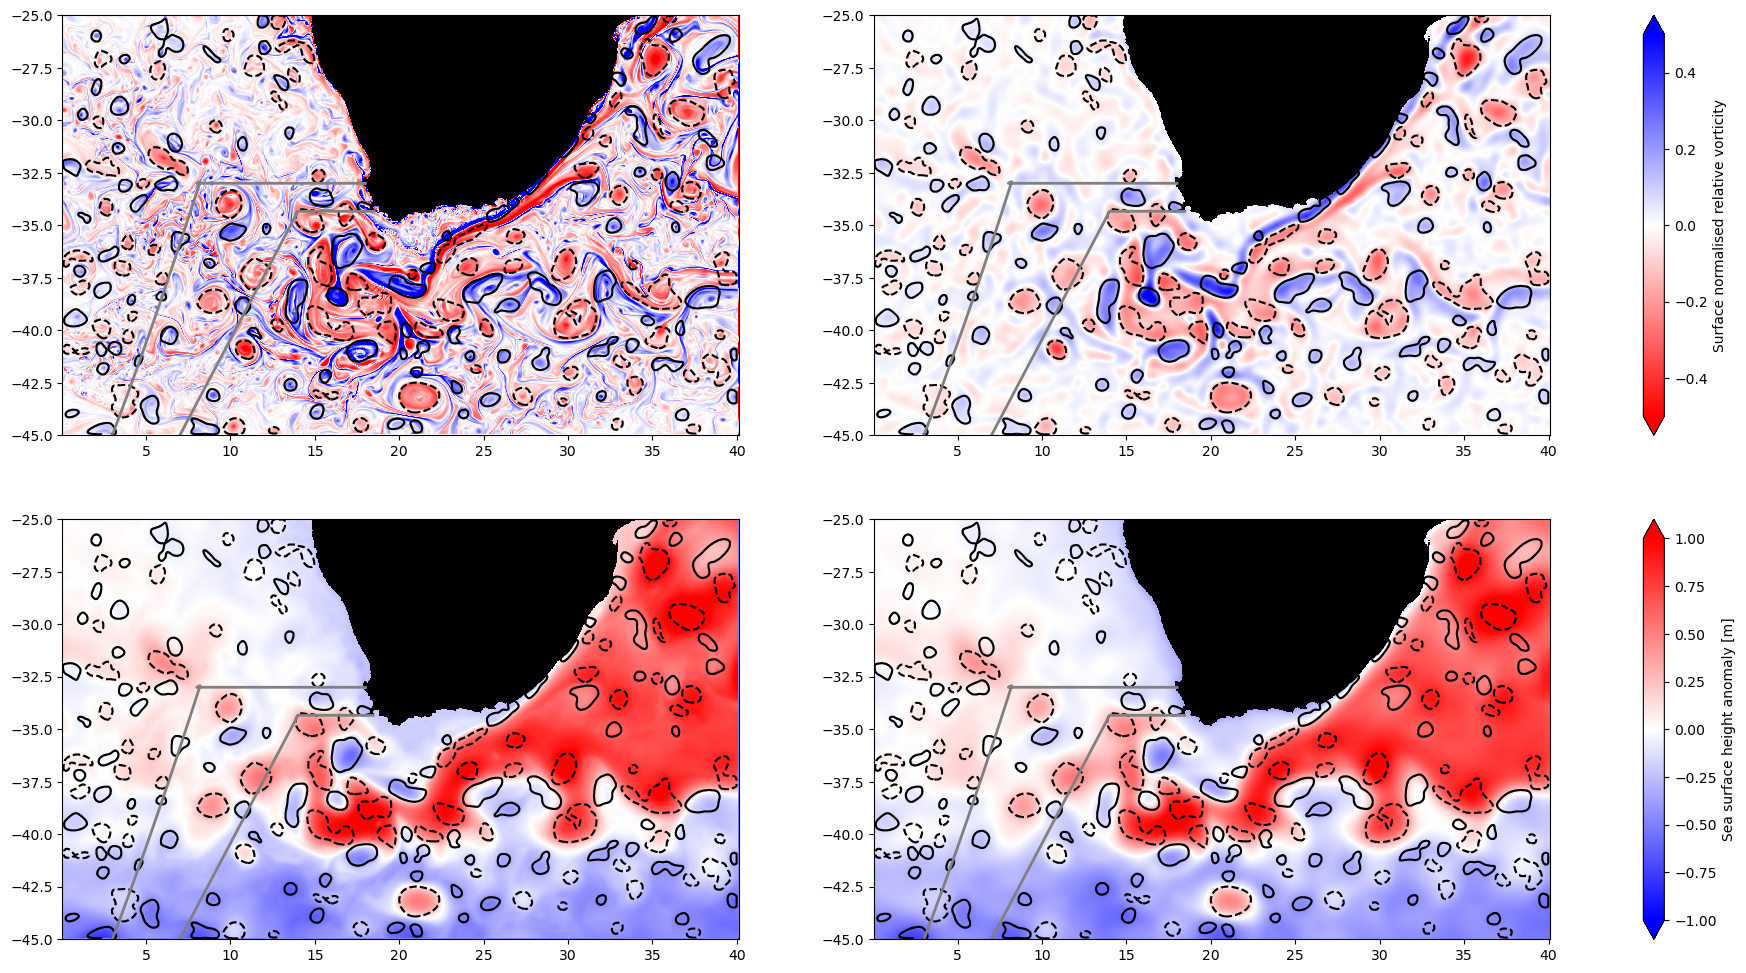

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12)) 

vmin_vort, vmax_vort = -0.5, 0.5
vmin_ssh, vmax_ssh = -1, 1

cm1 = axes[0, 0].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vort.isel(t=0), vmin=vmin_vort, vmax=vmax_vort, cmap='bwr_r')
plot_background(axes[0, 0], mesh_mask, ds)
cm2 = axes[0, 1].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vort_smoothed.isel(t=0), vmin=vmin_vort, vmax=vmax_vort, cmap='bwr_r')
plot_background(axes[0, 1], mesh_mask, ds)

cm3 = axes[1, 0].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, ssh-ssh.mean(), vmin=vmin_ssh, vmax=vmax_ssh, cmap='bwr')
plot_background(axes[1, 0], mesh_mask, ds)
cm4 = axes[1, 1].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, ssh_smoothed-ssh_smoothed.mean(), vmin=vmin_ssh, vmax=vmax_ssh, cmap='bwr')
plot_background(axes[1, 1], mesh_mask, ds)

cbar1 = fig.colorbar(cm1, ax=axes[0, :], orientation='vertical', extend='both')
cbar1.set_label("Surface normalised relative vorticity")
cbar2 = fig.colorbar(cm3, ax=axes[1, :], orientation='vertical', extend='both')
cbar2.set_label("Sea surface height anomaly [m]")

for ax in axes.flat:
    ax.plot(combined_lon, combined_lat, color='gray', linewidth=2)
    ax.plot(Ansorge_lon, Ansorge_lat, color='gray', linewidth=2)
    ax.set_ylim(-45, -25)